# Lab 2 - Creating Entanglement with Qiskit

This lab demonstrates interesting properties of *entangled* qubits. In particular, we will consider two experiments:
- **CHSH Inequality Violation** - this shows that quantum mechanics *cannot* be explained by a local hidden variable theory
- **Teleportation** - teleport an arbitrary quantum state using an entangled qubit pair as a resource

In particular, this lab demonstrates how to use new features from IBM Quantum 
- **Primitives** - abstract measurement and error mitigation for scalable quantum computing
- **Dynamic Circuits** - mid-circuit measurement and feed-forward within the qubits' coherence time

## Getting Started

This lab requires a Qiskit Runtime service instance. If you haven't done so already, follow the instructions in the Qiskit [Getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up. TODO: include video links and such.

Start by importing some libraries we need, including the `Sampler` and `Estimator` primitives from Qiskit Runtime. Then create your Qiskit Runtime service instance and load the `ibmq_qasm_simulator` as the backend.

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Sampler, Session

In [2]:
service = QiskitRuntimeService()
backend = service.get_backend('ibmq_qasm_simulator')

## CHSH Inequality Violation

### Warm Up

Create circuits that put the qubit in the excited $|1\rangle$ and superposition $|+\rangle$ states, respectivly, and measure them in different bases. This is done first with the `Sampler` primitive (which is most similar to the `backend.run()` used in the previous lab), and then with the `Estimator` primitive to show how measurement is abstracted in that we do not need to worry about rotating the qubit into the appropriate measurement basis. The primitives will be executed withing the `Session` context which allows efficiency to optimize workloads.

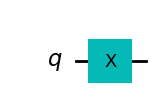

In [3]:
# create excited |1> state
qc_1 = QuantumCircuit(1)
qc_1.x(0)
qc_1.draw('mpl')


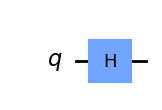

In [4]:
# create superposition |+> state
qc_plus = QuantumCircuit(1)
qc_plus.h(0)
qc_plus.draw('mpl')

### Sampler Primitive

First use the `Sampler` to measure qubits in the $Z$-basis (the physical basis in which qubits are measured). The `Sampler` will count the number of outcomes of the $|0\rangle$ state and $|1\rangle$ state, normalized by the number of shots (experiments performed). The `Sampler` also offers the ability to easily perform error mitigation (which is covered in Lab 5), which modifies this calculation, and hence the outcomes are refered to as *quasi-probabilities*.

Measurments must be present in the circuit when using the `Sampler` primitive. Then the `Session` context is opened, the `Sampler` is instantiated, and `sampler.run()` is used to send the circuits to the backend, similar to the `backend.run()` syntax you may already be familiar with.

In [5]:
qc_1.measure_all()
qc_plus.measure_all()
with Session(service=service, backend=backend) as session:
    sampler = Sampler()
    job_1 = sampler.run(qc_1)
    job_plus = sampler.run(qc_plus)

In [6]:
job_1.result().quasi_dists

[{1: 1.0}]

In [7]:
job_plus.result().quasi_dists

[{1: 0.49575, 0: 0.50425}]

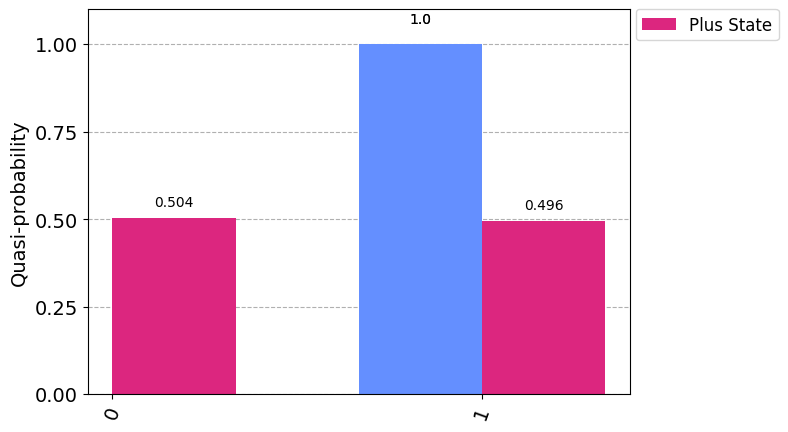

In [8]:
legend = ["Excited State", "Plus State"]
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

The result for the excited state is always $|1\rangle$ wheres it is roughly half $|0\rangle$ and half |1\rangle$ for the plus superposition state. This is because the $|0\rangle$ and $|1\rangle$ states are *eigenstates* of the $Z$ operator (with $+1$ and $-1$ eigenvalues, respectively).

Let's switch and measure in the $X$ basis. Using the `Sampler` we must rotate the qubit from the $X$-basis to the $Z$-basis for measurement (because that is the only basis we can actually perform measurement in).

In [9]:
qc_1.remove_final_measurements()
qc_plus.remove_final_measurements()

# rotate into the X-basis
qc_1.h(0)
qc_plus.h(0)

qc_1.measure_all()
qc_plus.measure_all()

In [10]:
with Session(service=service, backend=backend) as session:
    sampler = Sampler()
    job_1 = sampler.run(qc_1)
    job_plus = sampler.run(qc_plus)

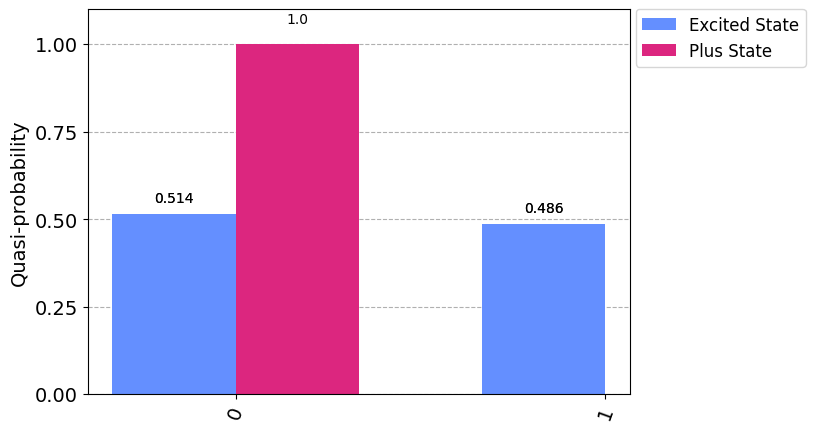

In [11]:
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

Now we see the opposite: the plus superposition always give the 1 result, hence an eigenstate of the $X$ operator, whereas the excited $|1\rangle$ yields a roughtly fifty-fifty split. The $|+\rangle$ and $|-\rangle$ states are eigenstates of the $X$ operator, with eigenvalues $+1$ and $-1$, respectively. This is good to remember when considering how the `Estimator` works in the next subsection. 

### Estimator Primitive

The Qiskit Runtime Primitives allow us to abstract measurement into the `Estimator` primitive, where it is specified as an *observable*. In particular, we can construct the same circuits, the excited $|1\rangle$ and superposition $|+\rangle$ as before. However, in the case of the `Estimator`, we *do not* add measurements to the circuit. Instead, specify a list of observables which take the form of Pauli strings. In our case for a measurement of a single qubit, we specify `'Z'` for the $Z$-basis and `'X'` for the $X$-basis.

In [17]:
qc2_1 = QuantumCircuit(1)
qc2_1.x(0)

qc2_plus = QuantumCircuit(1)
qc2_plus.h(0)

obsvs = list(SparsePauliOp(['Z', 'X']))

In [14]:
with Session(service=service, backend=backend) as session:
    estimator = Estimator()
    job2_1 = estimator.run([qc2_1]*len(obsvs), observables=obsvs)
    job2_plus = estimator.run([qc2_plus]*len(obsvs), observables=obsvs)

In [28]:
job2_1.result()

EstimatorResult(values=array([-1.    , -0.0225]), metadata=[{'variance': 0.0, 'shots': 4000}, {'variance': 0.99949375, 'shots': 4000}])

In [29]:
# TODO: make this into module that outputs a nice table
print(f'    |   <Z>   |   <X> ')
print(f'----|------------------')
print(f'|1> | {job2_1.result().values[0]}    | {job2_1.result().values[1]}')
print(f'|+> | {job2_plus.result().values[0]} | {job2_plus.result().values[1]}')

    |   <Z>   |   <X> 
----|------------------
|1> | -1.0    | -0.0225
|+> | -0.0085 | 1.0


Just as before, we see the $|1\rangle$ state expectation in the $Z$-basis is $-1$ (corresponding to its eigenvalue) and around zero in the $X$-basis (average over $+1$ and $-1$ eigenvalues), and vice-versa for the $|+\rangle$ state (although its eigenvalue of the $X$ operators is $+1$).

## CHSH Inequality

In [33]:
q0_obsvs = [SparsePauliOp('X'), SparsePauliOp('Z')]
q1_obsvs = [SparsePauliOp(['X', 'Z'], coeffs=[1., -1.]), SparsePauliOp(['X', 'Z'], coeffs=[1., 1.])]

In [89]:
obsvs = [q0_obsvs[0].tensor(q1_obsvs[0]) + q0_obsvs[1].tensor(q1_obsvs[1]),
         q0_obsvs[0].tensor(q1_obsvs[1]) - q0_obsvs[1].tensor(q1_obsvs[0])]
        #  q0_obsvs[1].tensor(q1_obsvs[0]) + q0_obsvs[0].tensor(q1_obsvs[1]),
        #  q0_obsvs[1].tensor(q1_obsvs[1]) - q0_obsvs[0].tensor(q1_obsvs[0]),]

In [90]:
obsvs

[SparsePauliOp(['XX', 'XZ', 'ZX', 'ZZ'],
               coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j]),
 SparsePauliOp(['XX', 'XZ', 'ZX', 'ZZ'],
               coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.-0.j])]

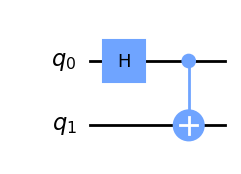

In [66]:
qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.cx(0, 1)
qc1.draw('mpl')

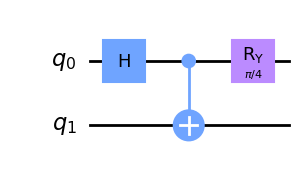

In [81]:
from qiskit.qasm import pi

qc2 = QuantumCircuit(2)
qc2.h(0)
qc2.cx(0, 1)
qc2.ry(pi/4, 0)
qc2.draw('mpl')

In [82]:
qcs

In [91]:
from qiskit_ibm_runtime import Options

options = Options()
options.execution.shots = int(1e5)

# qcs = [qc1, qc2]

with Session(service=service, backend=backend) as session:
    estimator = Estimator(options=options)
    job = estimator.run([qc1]*len(obsvs), observables=obsvs)

In [92]:
job.result()

EstimatorResult(values=array([2.0033 , 1.99202]), metadata=[{'variance': 1.9999944492, 'shots': 100000}, {'variance': 1.9999573019999999, 'shots': 100000}])